In [218]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import re
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [252]:
data = pd.read_csv('./data/after_clean.csv', encoding='gb18030', index_col=0)
data = data[data['ItemName'] != 'No']
data.shape

(143541, 29)

In [121]:
category2 = ['拼图', '磁', '点读', '拉杆|提拉', '包', '积木', '电', '车']

def categ(itemname, category):
    '''
    itemname: string of item name
    category: list of all categories
    '''
    
    for i in category:
        if re.search(i,itemname) != None:
            return i        
    return 'No Category'

In [122]:
data['Category2'] = data['ItemName'].apply(lambda x: categ(x,category2))

In [126]:
data = data[data['Category2'] != 'No Category']
data.shape

(132799, 31)

In [130]:
data = data.loc[:,['AlipayAccount','Category2']]
data.reset_index(inplace=True, drop=True)

In [142]:
# Filter accounts who buy more than one time
accounts_2 = list(customer_freq[customer_freq['Category2'] > 1].index)
data = data.loc[data['AlipayAccount'].isin(accounts_2)]

In [154]:
data.head()

,AlipayAccount,Category2
14,13808855801,积木
28,18047121272,积木
36,silvia80@mail.china.com,积木
39,17501565888,包
43,15841715444,包


## Category vs. Sold Volume

In [232]:
items_count = pd.DataFrame({'ItemName':['Magnetic Toys','Bags','Building Block','Study Toys','Electrical Toys',\
                                        'Puzzle','Trolley Case','Car Toys'],
                            'Counts':[13863,10166,6145,3143,2044,1678,1478,1216]})
items_count

,ItemName,Counts
0,Magnetic Toys,13863
1,Bags,10166
2,Building Block,6145
3,Study Toys,3143
4,Electrical Toys,2044
5,Puzzle,1678
6,Trolley Case,1478
7,Car Toys,1216


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

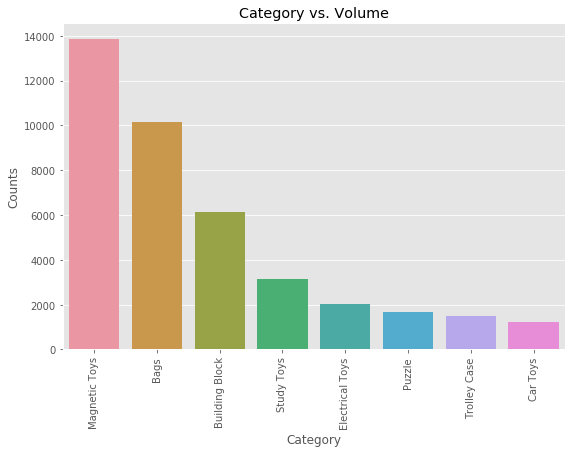

In [249]:
plt.figure(figsize=(9, 6))
sns.barplot("ItemName","Counts",data=items_count)
plt.xlabel('Category')
plt.title('Category vs. Volume')
plt.xticks(rotation=90)

## Items bought by each consumer

In [160]:
items_freq = {}
for i in data['AlipayAccount'].unique():
    tmp = data[data['AlipayAccount'] == i]
    items_freq[i] = tmp['Category2'].unique()

In [173]:
items = []
for i in items_freq.values():
    items.append(str(i))
items = pd.DataFrame(items)
items.columns = ['items']

In [194]:
category2 = ['拼图', '磁', '点读', '拉杆|提拉', '包', '积木', '电', '车']

In [203]:
cate = {'pingtu':'拼图',
        'ci':'磁',
        'diandu':'点读',
        'lagan':'拉杆|提拉',
        'bao':'包',
        'jimu':'积木',
        'dian':'电',
        'che':'车'}

def column_creat(col_list, df):
    list_ = []
    for i in df['items']:
        if re.search(cate[col_list], i) != None:
            list_.append(1)
        else:
            list_.append(0)
    return list_

In [211]:
items['拼图'] = column_creat('pingtu',items)
items['磁'] = column_creat('ci',items)
items['点读'] = column_creat('diandu',items)
items['拉杆|提拉'] = column_creat('lagan',items)
items['包'] = column_creat('bao',items)
items['积木'] = column_creat('jimu',items)
items['电'] = column_creat('dian',items)
items['车'] = column_creat('che',items)

In [251]:
items.columns = ['items','Puzzle','Magnetic Toys','Study Toys','Trolley Case','Bags',\
                 'Building Block','Electrical Toys','Car Toys']
items.iloc[14:20,:]

,items,Puzzle,Magnetic Toys,Study Toys,Trolley Case,Bags,Building Block,Electrical Toys,Car Toys
14,['积木' '车' '磁'],0,1,0,0,0,1,0,1
15,['拉杆|提拉'],0,0,0,1,0,0,0,0
16,['包'],0,0,0,0,1,0,0,0
17,['包'],0,0,0,0,1,0,0,0
18,['包' '车'],0,0,0,0,1,0,0,1
19,['包' '积木'],0,0,0,0,1,1,0,0


## Apriori algorithm

In [240]:
final_data = items.iloc[:,1:]

In [245]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

In [247]:
frequent_itemsets = apriori(final_data, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values('confidence', ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Puzzle),(Bags),0.063426,0.289860,0.026543,0.418494,1.443777,0.008159,1.221207
5,(Car Toys),(Electrical Toys),0.035734,0.063003,0.003749,0.104907,1.665121,0.001497,1.046816
1,(Bags),(Puzzle),0.289860,0.063426,0.026543,0.091573,1.443777,0.008159,1.030984
6,"(Magnetic Toys, Bags)",(Puzzle),0.014269,0.063426,0.001028,0.072034,1.135718,0.000123,1.009276
4,(Electrical Toys),(Car Toys),0.063003,0.035734,0.003749,0.059501,1.665121,0.001497,1.025271
3,(Electrical Toys),(Puzzle),0.063003,0.063426,0.003688,0.058541,0.922988,-0.000308,0.994812
2,(Puzzle),(Electrical Toys),0.063426,0.063003,0.003688,0.058151,0.922988,-0.000308,0.994848
8,"(Bags, Building Block)",(Puzzle),0.023702,0.063426,0.001330,0.056122,0.884851,-0.000173,0.992262
9,(Puzzle),"(Bags, Building Block)",0.063426,0.023702,0.001330,0.020972,0.884851,-0.000173,0.997212
7,(Puzzle),"(Magnetic Toys, Bags)",0.063426,0.014269,0.001028,0.016206,1.135718,0.000123,1.001969
